## Pair Programming - Regresión lineal V Parte B

### Normalización

---

In [111]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import math 
import researchpy as rp

import warnings
warnings.filterwarnings('ignore')

In [112]:
df = pd.read_csv("../archivos/metro_1.csv", index_col=0)

Filtramos el df por la variable respuesta intentando quedarnos por la curva de en medio, para quedarnos sin outliers y aunque tengamos menos datos que el resultado sea más robusto

In [113]:
df_2= df[(df['traffic_volume'] >2000) & (df['traffic_volume'] <3800)]
df_2.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
10,None,290.97,0.0,0.0,20,Clouds,few clouds,2012-10-02 19:00:00,3539
11,None,289.38,0.0,0.0,1,Clear,sky is clear,2012-10-02 20:00:00,2784
12,None,288.61,0.0,0.0,1,Clear,sky is clear,2012-10-02 21:00:00,2361
20,None,278.62,0.0,0.0,1,Clear,sky is clear,2012-10-03 05:00:00,2718
30,None,290.65,0.0,0.0,20,Clouds,few clouds,2012-10-03 19:00:00,3591


In [114]:
stats.shapiro(df_2['traffic_volume'])

ShapiroResult(statistic=0.9777806401252747, pvalue=3.4828861349044817e-38)

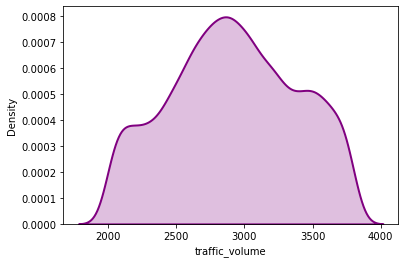

In [115]:
sns.distplot(df_2['traffic_volume'], hist= False, color= 'purple', kde_kws= {"shade": True, "linewidth": 2});

In [116]:
# Aplicamos el método boxcox para normalizar la variable respuesta 
df_2['traffic_box'], lambda_ajustada = stats.boxcox(df_2['traffic_volume'])

In [117]:
lambda_ajustada

0.9269771683536795

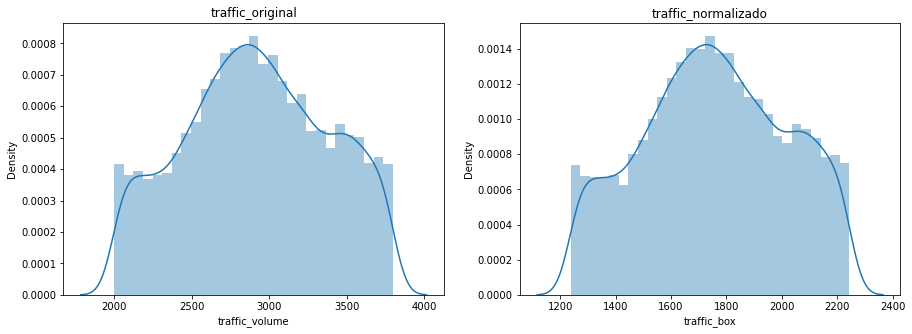

In [118]:
# Visualizamos el antes y el después de la normalización

fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('traffic_original')
axes[1].set_title('traffic_normalizado')

sns.distplot(df_2['traffic_volume'] ,ax = axes[0])
sns.distplot(df_2['traffic_box'], ax = axes[1]);

Vamos a testear las asunciones de la nueva muestra de datos 

- Asunción de normalidad

In [119]:
stats.shapiro(df_2['traffic_box'])

ShapiroResult(statistic=0.9777753949165344, pvalue=3.4544134316675586e-38)

Los datos siguen sin tener una distribución normal pero se ajusta más que la muestra anterior, por lo que seguimos trabajando con este filtrado de los datos para la siguiente parte de estandarización.


- Asunción de homocedasticiad

In [120]:
categoria = df_2['weather_main'].unique().tolist()

In [121]:
clouds = df_2[df_2["weather_main"] == 'Clouds']["traffic_box"]
clear = df_2[df_2["weather_main"] == 'Clear']["traffic_box"]
rain = df_2[df_2["weather_main"] == 'Rain']["traffic_box"]
drizzle = df_2[df_2["weather_main"] == 'Drizzle']["traffic_box"]
mist = df_2[df_2["weather_main"] == 'Mist']["traffic_box"]
haze = df_2[df_2["weather_main"] == 'Haze']["traffic_box"]
fog = df_2[df_2["weather_main"] == 'Fog']["traffic_box"]
thunderstorm = df_2[df_2["weather_main"] == 'Thunderstorm']["traffic_box"]
snow = df_2[df_2["weather_main"] == 'Snow']["traffic_box"]
squall = df_2[df_2["weather_main"] == 'Squall']["traffic_box"]
smoke = df_2[df_2["weather_main"] == 'Smoke']["traffic_box"]

In [122]:
levene_test= stats.levene(clouds,clear,rain,drizzle,mist,haze,fog,thunderstorm,snow,squall,smoke)
levene_test

LeveneResult(statistic=4.41972428167341, pvalue=3.125685858764262e-06)

El p-valor es < 0.05, rechazamos la HO, por lo que la varianza en la variable categórica weather_main es heterocedástica.

In [123]:
df_2.head(2)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,traffic_box
10,None,290.97,0.0,0.0,20,Clouds,few clouds,2012-10-02 19:00:00,3539,2101.064038
11,None,289.38,0.0,0.0,1,Clear,sky is clear,2012-10-02 20:00:00,2784,1681.830454


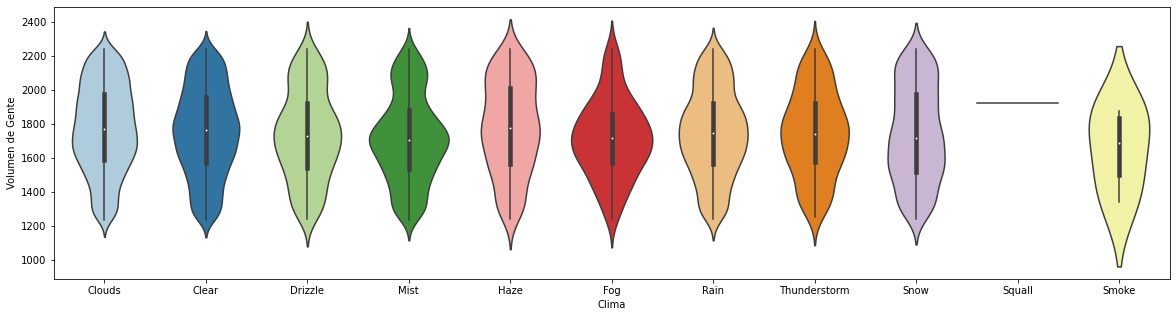

In [124]:
plt.figure( figsize=(20,5))

sns.violinplot(x= "weather_main", y= "traffic_box", data=df_2, palette="Paired")
#plt.set_tittle("Distribución clima por día/hora")
plt.ylabel("Volumen de Gente")
plt.xlabel("Clima");


Vemos que en este Violinplot las medianas están un poco más alineadas que antes de hacer la filtración.

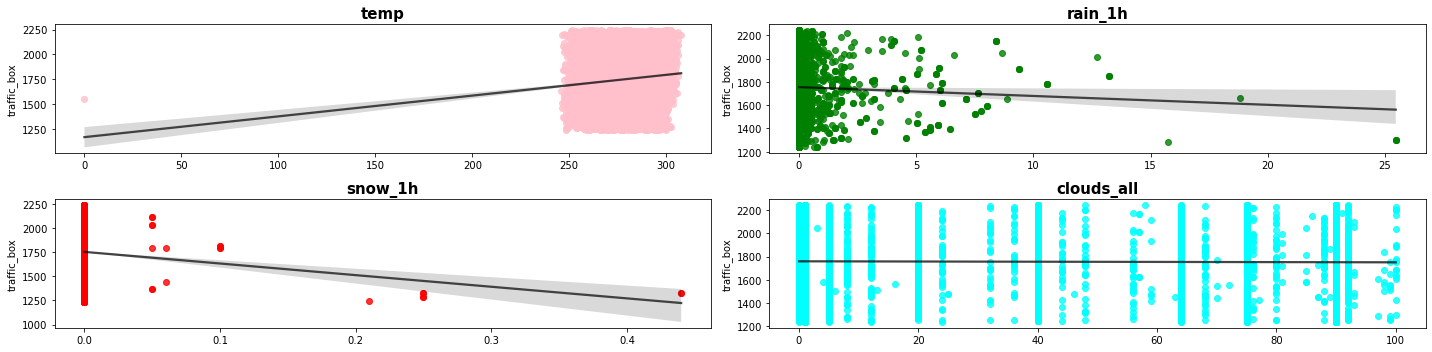

In [125]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 5))

lista_colores = ["pink", "green", "red", "cyan", "magenta", "orange"]

axes = axes.flat


columnas_numeric = df_2.select_dtypes(include = np.number).drop(['traffic_volume', 'traffic_box'], axis=1)
columnas_numeric = columnas_numeric.columns


for i, colum in enumerate(columnas_numeric): 
    sns.regplot(data = df_2, x = colum, y = 'traffic_box', color = lista_colores[i], line_kws = {"color": "black", "alpha": 0.7 }, ax = axes[i])
    
   
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")

    axes[i].tick_params(labelsize = 10)

    axes[i].set_xlabel("")

fig.tight_layout();

In [126]:
#Preguntar

Hemos sacado las gráficas para evaluar la homocedasticidad en las variables numéricas y ...

- Asunción de independencia

In [127]:
crosstab, test_results, expected = rp.crosstab(df_2["rain_1h"], df_2["weather_main"], test= "chi-square", expected_freqs= True, prop= "cell")

In [128]:
crosstab

weather_main                                                 \
weather_main        Clear Clouds Drizzle   Fog  Haze   Mist   Rain Smoke   
rain_1h                                                                    
0.0                 29.05  31.87    3.16  1.43  2.57  10.05   7.57  0.04   
0.25                 0.00   0.00    0.08  0.02  0.02   0.20   1.11  0.00   
0.28                 0.00   0.00    0.00  0.00  0.00   0.00   0.02  0.00   
0.29                 0.00   0.00    0.01  0.00  0.00   0.00   0.01  0.00   
0.3                  0.00   0.00    0.02  0.00  0.00   0.04   0.11  0.00   
...                   ...    ...     ...   ...   ...    ...    ...   ...   
13.21                0.00   0.00    0.00  0.00  0.00   0.01   0.01  0.00   
15.75                0.00   0.00    0.00  0.00  0.00   0.00   0.01  0.00   
18.8                 0.00   0.00    0.00  0.00  0.00   0.00   0.01  0.00   
25.46                0.00   0.00    0.00  0.00  0.00   0.01   0.01  0.00   
All                 29.05  31.87    3.61  1.50  2.64  11.12  11.41  0.04   

                                                
weather_main  Snow Squall Thunderstorm     All  
rain_1h                                         
0.0           6.33   0.00         1.67   93.74  
0.25          0.08   0.00         0.05    1.55  
0.28          0.00   0.00         0.01    0.03  
0.29          0.00   0.00         0.00    0.02  
0.3           0.00   0.00         0.02    0.18  
...            ...    ...          ...     ...  
13.21         0.00   0.00         0.01    0.03  
15.75         0.00   0.00         0.00    0.01  
18.8          0.00   0.00         0.00    0.01  
25.46         0.00   0.00         0.01    0.03  
All           6.47   0.01         2.30  100.00  

[143 rows x 12 columns]

In [129]:
expected

weather_main                                                   \
weather_main        Clear       Clouds     Drizzle         Fog        Haze   
rain_1h                                                                      
0.00          3012.689262  3305.146963  374.008406  155.602495  273.710412   
0.25            49.964570    54.814895    6.202820    2.580622    4.539407   
0.28             0.871475     0.956074    0.108189    0.045011    0.079176   
0.29             0.580983     0.637383    0.072126    0.030007    0.052784   
0.30             5.809834     6.373825    0.721258    0.300072    0.527838   
...                   ...          ...         ...         ...         ...   
12.70            0.290492     0.318691    0.036063    0.015004    0.026392   
13.21            0.871475     0.956074    0.108189    0.045011    0.079176   
15.75            0.290492     0.318691    0.036063    0.015004    0.026392   
18.80            0.290492     0.318691    0.036063    0.015004    0.026392   
25.46            0.871475     0.956074    0.108189    0.045011    0.079176   

                                                                        \
weather_main         Mist         Rain     Smoke        Snow    Squall   
rain_1h                                                                  
0.00          1152.958243  1182.953905  3.749458  671.152928  0.937364   
0.25            19.121475    19.618944  0.062184   11.130875  0.015546   
0.28             0.333514     0.342191  0.001085    0.194143  0.000271   
0.29             0.222343     0.228127  0.000723    0.129429  0.000181   
0.30             2.223427     2.281273  0.007231    1.294288  0.001808   
...                   ...          ...       ...         ...       ...   
12.70            0.111171     0.114064  0.000362    0.064714  0.000090   
13.21            0.333514     0.342191  0.001085    0.194143  0.000271   
15.75            0.111171     0.114064  0.000362    0.064714  0.000090   
18.80            0.111171     0.114064  0.000362    0.064714  0.000090   
25.46            0.333514     0.342191  0.001085    0.194143  0.000271   

                           
weather_main Thunderstorm  
rain_1h                    
0.00           238.090564  
0.25             3.948662  
0.28             0.068872  
0.29             0.045915  
0.30             0.459147  
...                   ...  
12.70            0.022957  
13.21            0.068872  
15.75            0.022957  
18.80            0.022957  
25.46            0.068872  

[142 rows x 11 columns]

In [130]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 1410.0) =,7046.4457
1,p-value =,0.0000
2,Cramer's V =,0.2524


Vemos que el p-value es menor de 0.05 así que rechazamos la H0, por tanto nuestras variables "weather_main" y "rain_1h" son dependientes. Además vemos que los resultados del crosstab comparados con los del expected son muy diferentes también.

Concluimos que al final no cumplimos ninguna de las asunciones.

---

In [131]:
df_2.to_csv('../archivos/metro_2.csv')